<a href="https://colab.research.google.com/github/bgalerne/mva_stochastic_models/blob/master/Gatys_texture_synthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This practical session is based on
**[Texture Synthesis Using Convolutional Neural Networks](https://papers.nips.cc/paper/5633-texture-synthesis-using-convolutional-neural-networks)**
by Leon Gatys, Alexander S. Ecker, and Matthias Bethge, NIPS 2015

Most of the code is from L. Gatys' repo
https://github.com/leongatys/PytorchNeuralStyleTransfer

Let us recall the algorithm proposed by Gatys et al.
Given an example image $u$ and a random initialization $x_0$, 
one optimizes the loss function 
$$
E(x) = \sum_{\text{for selected layers } L} w_L\left\| G^L(x) - G^L(u) \right\|^2_F
$$
where $\|\cdot\|_F$ is the Frobenius norm and for an image $y$ and a layer index $L$ $G^L(y)$ denotes the Gram matrix of the VGG-19 features at layer $L$:
if $V^L(y)$ is the feature response of $y$ at layer $L$ that has spatial size $w\times h$ and $n$ channels, 
$$
G^L(y) = \frac{1}{w h}\sum_{k\in \{0,\dots,w-1\}\times\{0,\dots,h-1\}} V^L(y)_k V^L(y)_k^T \in \mathbb{R}^{n\times n}.
$$
The optimization is done using the L-BFGS algorithm.





**Exercice:**


1. Go through the code and execute the algorithm.

2. Verify that the quality of the output texture decreases if one uses less VGG-19 layers.

3. Pick one of the following problems:

A/ (easy) Observe that for some image the color is inconsistant. Propose and implement a solution to correct the output color distribution.

B/ (intermediate) Add a term to the energy that would enforce a consistency with the original Fourier spectrum of each color channel. What is the interest of this approach.
What are the textures for which it improves or degrades the quality of the result.

C/ (intermediate) Replace $F$ so that the spatial average of ALL the VGG-19 layers is preserved. Compare with the original model. What are the interests of this approach ?

D/ (intermediate) Replace the loss to preserve the mean and covariance of VGG-19 pool layers. Are the results similar?

E/ (advanced) As proposed in 
[Texture Networks: Feed-forward Synthesis of Textures and Stylized Images](http://proceedings.mlr.press/v48/ulyanov16.pdf) by Ulyanov et al., ICML 2016,
train a generative neural networks using Gatys et al's cost function $F$ as a discriminative network. A PyTorch implementation by [Jorge Gutierrez](https://sites.google.com/view/jorge-gutierrezor/home) can be found [here](https://github.com/JorgeGtz/TextureNets_implementation).



In [2]:
import time
import os 
image_dir = os.getcwd()+'/'
model_dir = os.getcwd()+'/'

import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision

from torchvision import transforms

from PIL import Image
from collections import OrderedDict

In [3]:
# get binary files for vgg19 parameters:
!wget -c --no-check-certificate https://bethgelab.org/media/uploads/pytorch_models/vgg_conv.pth
#get some texture images (images are 512x512)
!wget -c https://www.idpoisson.fr/galerne/mva/bark1001.png
!wget -c https://www.idpoisson.fr/galerne/mva/wall1003.png
!wget -c https://www.idpoisson.fr/galerne/mva/wall1029.png
!ls

--2021-03-07 22:06:04--  https://bethgelab.org/media/uploads/pytorch_models/vgg_conv.pth
Resolving bethgelab.org (bethgelab.org)... 46.38.232.246
Connecting to bethgelab.org (bethgelab.org)|46.38.232.246|:443... connected.
  Self-signed certificate encountered.
HTTP request sent, awaiting response... 200 OK
Length: 160198540 (153M) [text/plain]
Saving to: ‘vgg_conv.pth’

vgg_conv.pth        100%[===================>] 152.78M  8.43MB/s    in 46s     

2021-03-07 22:06:51 (3.31 MB/s) - ‘vgg_conv.pth’ saved [160198540/160198540]

--2021-03-07 22:06:51--  https://www.idpoisson.fr/galerne/mva/bark1001.png
Resolving www.idpoisson.fr (www.idpoisson.fr)... 134.206.83.41
Connecting to www.idpoisson.fr (www.idpoisson.fr)|134.206.83.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 707870 (691K) [image/png]
Saving to: ‘bark1001.png’

bark1001.png        100%[===================>] 691.28K  1.62MB/s    in 0.4s    

2021-03-07 22:06:52 (1.62 MB/s) - ‘bark1001.png’ saved [7

In [5]:
# pre and post processing for images
img_size = 512 
prep = transforms.Compose([transforms.Resize(img_size,img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

In [6]:
#vgg definition that conveniently let's you grab the outputs from any layer
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)
            
    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]
#get network
vgg = VGG()
vgg.load_state_dict(torch.load(model_dir + 'vgg_conv.pth'))
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

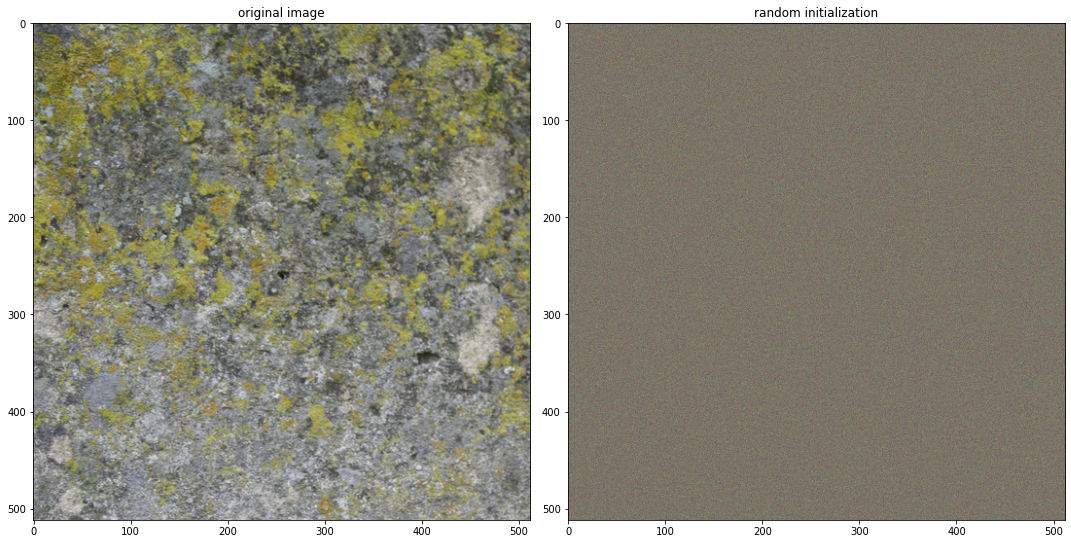

In [9]:
#load input image:
input_img_name = 'wall1003.png'#'bark1001.png'
input_img = Image.open(image_dir+input_img_name)
input_img_torch = prep(input_img).unsqueeze(0).cuda()

#random init:
opt_img = 10*torch.randn(input_img_torch.size()).type_as(input_img_torch.data)
opt_img.requires_grad=True

# display initialization
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 30))
axes[0].imshow(postp(input_img_torch.data[0].cpu().squeeze()))
axes[0].set_title('original image')
axes[1].imshow(postp(opt_img.data[0].cpu().squeeze()))
axes[1].set_title('random initialization')
fig.tight_layout()


In [10]:
# gram matrix and loss
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        G.div_(h*w)
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return(out)
#define layers, loss functions, weights and compute optimization targets
style_layers = ['r11','r21','r31','r41', 'r51'] 
loss_weights = [1/n**2 for n in [64,128,256,512,512]] #these are good weights settings
# Note that weights are equal to number of coefficients in the Gram matrices
loss_fns = [GramMSELoss()] * len(style_layers)
loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
    

#compute optimization targets
style_targets = [GramMatrix()(A).detach() for A in vgg(input_img_torch, style_layers)]

Iteration: 50, loss: 105253.617188


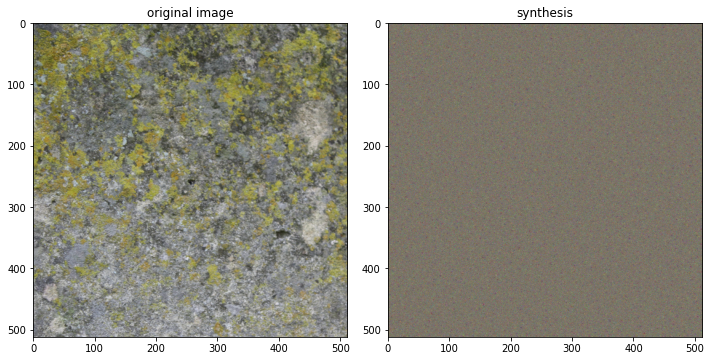

Iteration: 100, loss: 285.276245


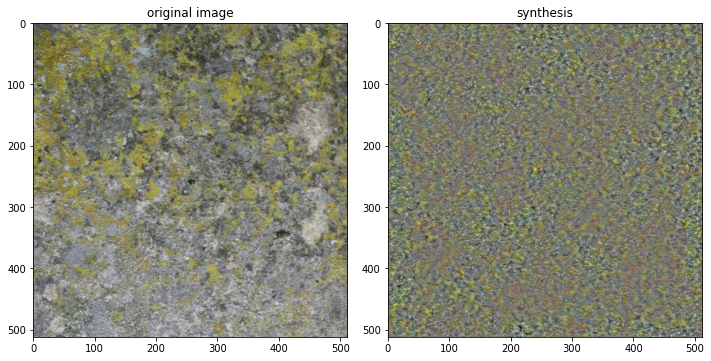

Iteration: 150, loss: 59.449234


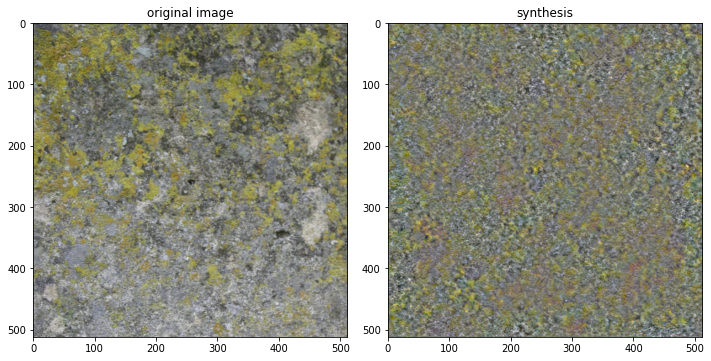

Iteration: 200, loss: 26.070076


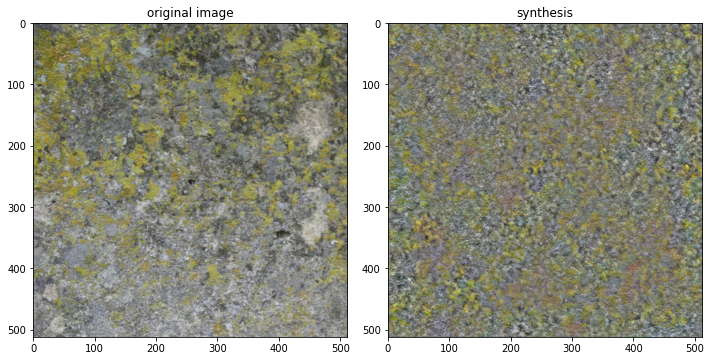

Iteration: 250, loss: 13.938779


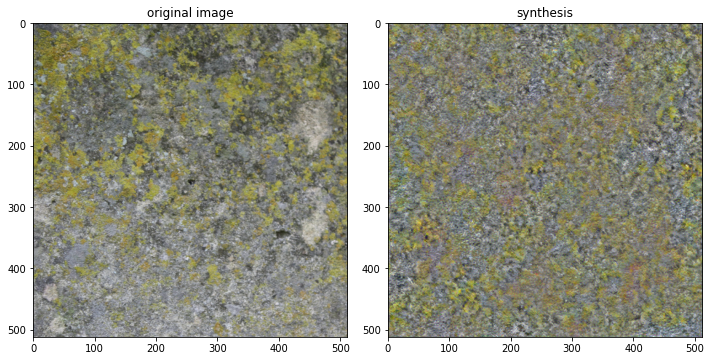

Iteration: 300, loss: 8.773835


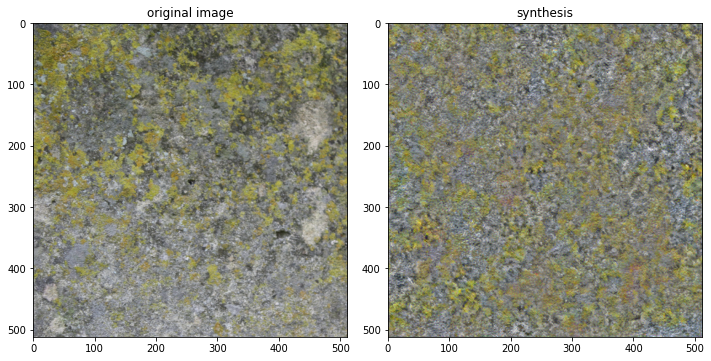

Iteration: 350, loss: 6.080873


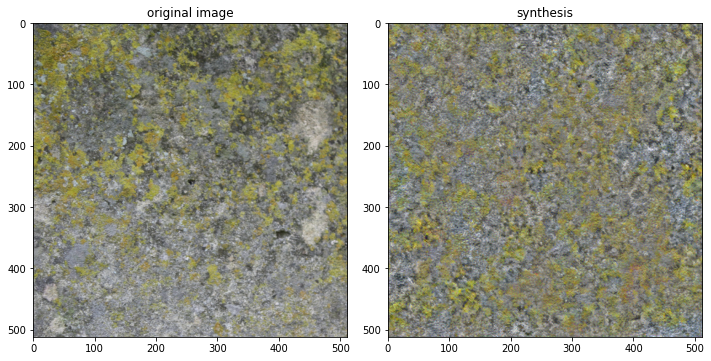

Iteration: 400, loss: 4.573106


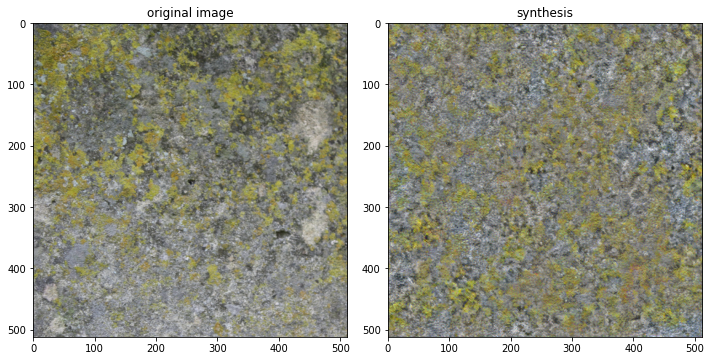

Iteration: 450, loss: 3.530937


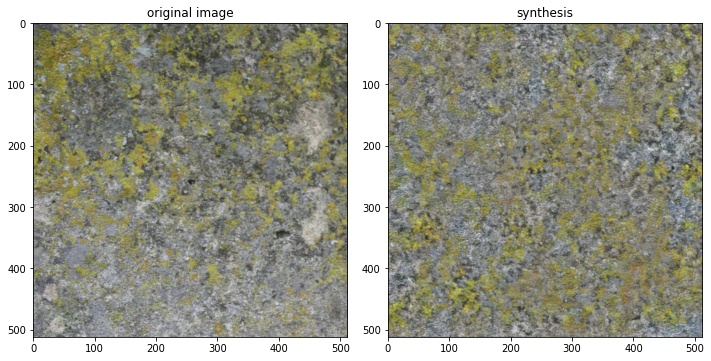

Iteration: 500, loss: 2.830658


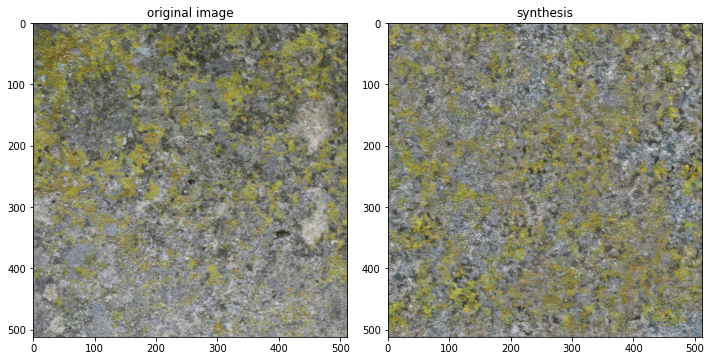

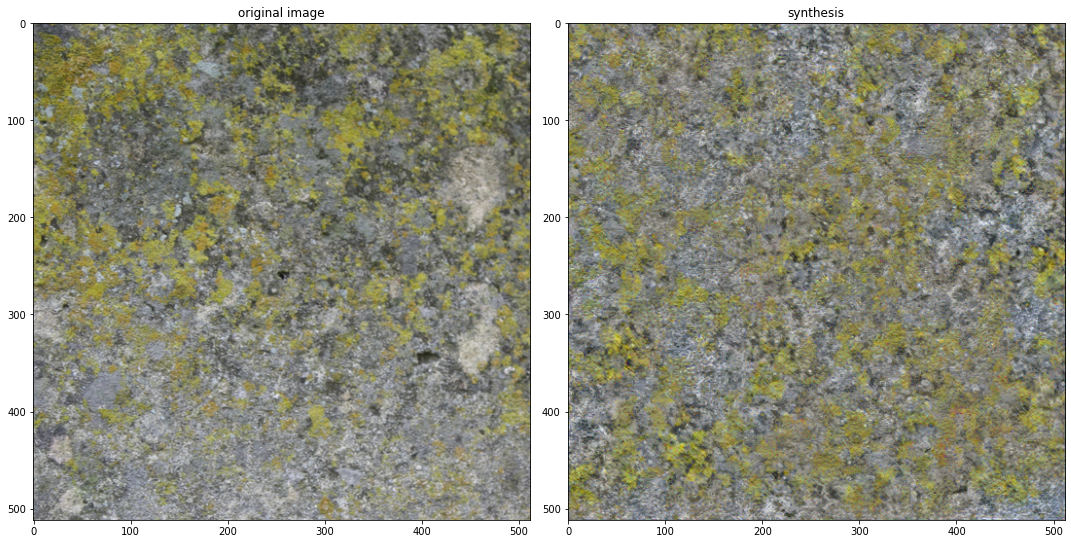

In [11]:
#run texture synthesis
max_iter = 500
show_iter = 50
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        out = vgg(opt_img, style_layers)
        layer_losses = [loss_weights[a] * loss_fns[a](A, style_targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.data))
#             print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
            #display result
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))
            axes[0].imshow(postp(input_img_torch.data[0].cpu().squeeze()))
            axes[0].set_title('original image')
            axes[1].imshow(postp(opt_img.data[0].cpu().squeeze()))
            axes[1].set_title('synthesis')
            fig.tight_layout()
            plt.pause(0.05)

        return loss
    
    optimizer.step(closure)
    
#display result
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 30))
axes[0].imshow(postp(input_img_torch.data[0].cpu().squeeze()))
axes[0].set_title('original image')
axes[1].imshow(postp(opt_img.data[0].cpu().squeeze()))
axes[1].set_title('synthesis')
fig.tight_layout()




